In [1]:
import numpy as np
import torch

from torch.nn import Linear
from torch.utils.data import DataLoader, TensorDataset

from functools import partial
from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ToySpatialTranscriptomics
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data

(1765050, 4)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


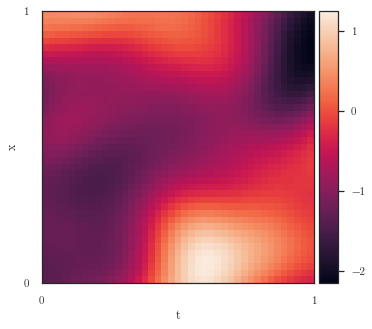

In [2]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False)

i = 49
orig_data = dataset.orig_data[1681*(i):1681*(i+1)]
tx = dataset.data[0][0]
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [torch.tensor(orig_data[:, 2]).view(num_t, num_x).t()],
    extent, nrows=1, ncols=1
)
block_dim = 2

ntest = 50
ntrain = len(dataset) - ntest
batch_size = 50
learning_rate = 1e-3

modes = 12
width = 32
in_channels = 3

def generate_neural_dataset(dataset, ntrain, ntest):
    s = 41
    tx, _ = dataset.data[0]
    grid = tx.t()
    grid = torch.tensor(grid.reshape(1,s,s,2), dtype=torch.float)

    data = torch.tensor(dataset.orig_data.reshape(len(dataset), s, s, 4), dtype=torch.float)
    y_train = data[:ntrain, ..., 2:3]
    x_train = data[:ntrain, ..., 3]
    y_test = data[ntrain:, ..., 2:3]
    x_test = data[ntrain:, ..., 3]

    x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
    x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                              batch_size=batch_size, shuffle=True)
    if ntest > 0:
        test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                              batch_size=ntest, shuffle=True)
        return train_loader, test_loader
    else:
        return train_loader

train_loader, test_loader = generate_neural_dataset(dataset, ntrain, ntest)

(328050, 4)
81 81


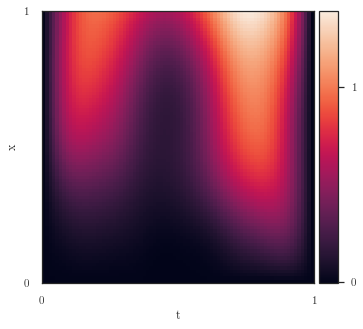

In [19]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False, highres=True)
i = torch.randint(50, torch.Size([1]))[0]

orig_data = dataset.orig_data[1681*(i):1681*(i+1)]

tx = dataset.data[i][0]
lf = dataset.data[i][1]

num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [lf.view(num_t, num_x).t()],
    extent, nrows=1, ncols=1
)

In [26]:
num_outputs = 10
basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)


20 20.0


In [ ]:
ntrain = 15
ntest = 5
batch_size = ntrain

datasets = list()
for i in range(ntrain + ntest):
    dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
    datasets.append(dataset)

In [ ]:
x_train = torch.cat([dataset.m_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
x_test = torch.cat([dataset.m_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
T_in = 11
grid = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntrain, 1, 1) # (1, 32, 32, 40, 1)
grid_test = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntest, 1, 1) # (1, 32, 32, 40, 1)

x_train = torch.cat([grid, x_train], dim=-1)
x_test = torch.cat([grid_test, x_test], dim=-1)
y_train = torch.cat([dataset.f_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
y_test = torch.cat([dataset.f_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
print('y', y_train.shape)
print('x', x_train.shape)
width = 20
modes = 4
in_channels = 11
train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                          batch_size=ntest, shuffle=True)

In [3]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

1188353


In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

In [ ]:
trainer.train(20);

Epoch 001/020 - Loss: 48.32 (0.94 0.76 43.69)
Epoch 002/020 - Loss: 40.68 (0.66 0.62 40.19)
Epoch 003/020 - Loss: 37.23 (0.55 0.52 36.59)
Epoch 004/020 - Loss: 33.20 (0.43 0.41 32.69)
Epoch 005/020 - Loss: 28.39 (0.31 0.28 26.47)
Epoch 006/020 - Loss: 23.34 (0.21 0.19 22.09)
Epoch 007/020 - Loss: 19.10 (0.14 0.13 18.00)
Epoch 008/020 - Loss: 15.84 (0.10 0.08 14.57)
Epoch 009/020 - Loss: 12.66 (0.06 0.05 11.50)
Epoch 010/020 - Loss: 10.81 (0.05 0.04 10.43)
Epoch 011/020 - Loss: 9.82 (0.04 0.04 9.96)


In [6]:
def show_result(x, y, out):
    if block_dim == 1:
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(x[0, :, i])#.shape, y.shape)
        axes[1].plot(y[0, :, 0])
        axes[1].plot(out[0, :, 0].detach())
    else:
        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x).t(),
                y[0, ..., 0].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )

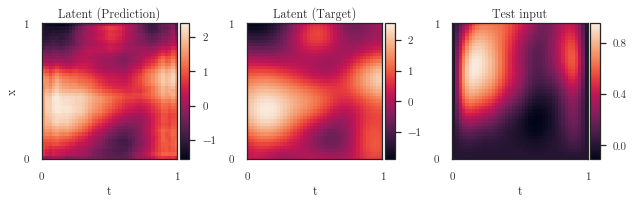

In [12]:
x, y = next(iter(test_loader))
out = model(x)
show_result(x, y, out)

(1681, 4)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


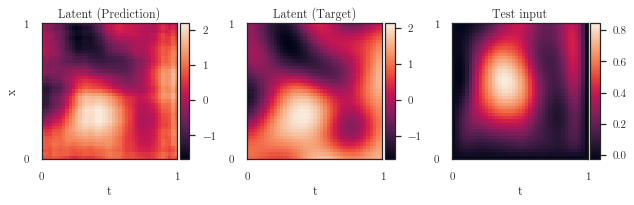

In [13]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=True)
train_loader = generate_neural_dataset(dataset, 1, 0)
x, y = next(iter(train_loader))
out = model(x)
show_result(x, y, out)

In [14]:
import torch.nn.functional as F
from lafomo.utilities.torch import smse, q2
f_mean_test = out.squeeze()
y_target = y.squeeze()
print(y.shape, f_mean_test.shape)
print(F.mse_loss(f_mean_test, y_target))

print(smse(y_target, f_mean_test).shape)


torch.Size([1, 41, 41, 1]) torch.Size([41, 41])
tensor(0.0423, grad_fn=<MseLossBackward>)
torch.Size([41, 41])


In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

In [6]:
weight = torch.rand((width, width, modes, modes))
x_ft = torch.rand((10, width, 41, 21))
out_ft = torch.rand((10, width, 41, 21))
print('weight', weight.shape)
print('x_ft', x_ft.shape)
print('out_ft', out_ft.shape)

weight torch.Size([32, 32, 12, 12])
x_ft torch.Size([10, 32, 41, 21])
out_ft torch.Size([10, 32, 41, 21])


In [24]:
from lafomo.utilities.torch import compl_mul2d
out_ft[:, :, :modes, :modes] = compl_mul2d(
    x_ft[:, :, :modes, :modes], weight
)
first = out_ft.clone()

print(x_ft[:, :, :modes, :modes].shape, weight.permute(1, 0, 2, 3).unsqueeze(0).shape)
out_ft[:, :, :modes, :modes] = torch.matmul(
    x_ft[:, :, :modes, :modes], weight.permute(1, 0, 2, 3)
)
second = out_ft.clone()
print(second.shape)

torch.Size([10, 32, 12, 12]) torch.Size([1, 32, 32, 12, 12])


RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 0